# **Airline Reviews Scraping**

---

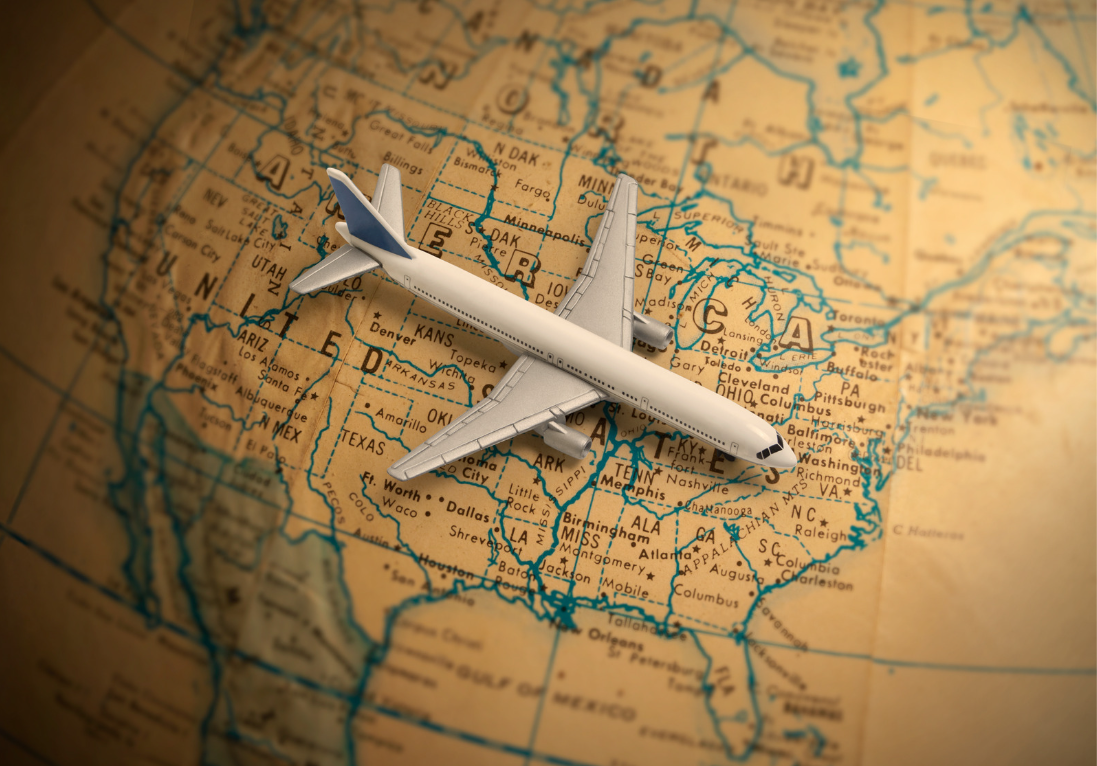

## **Table of Contents**

1. [Introduction](#Introduction)
    - 1.1 [Importing Libraries](#Importing-Libraries)
2. [Web Scraping](#Web-Scraping)
    - 2.1 [Scraping Airline Names](#Scraping-Airline-Names)
    - 2.2 [Scraping Airline Reviews](#Scraping-Airline-Reviews)
3. [Data Processing](#Data-Processing)
4. [Data Export](#Data-Export)
5. [Conclusion and Next Steps](#Conclusion-and-Next-Steps)
---

## **Introduction**
---
### **Project Overview**

- The airline industry is one of the most competitive sectors, where customer feedback plays a critical role in shaping the services offered by airlines. This project focuses on scraping and analyzing customer reviews from the [Skytrax website](https://www.airlinequality.com/), a leading source of airline reviews. By collecting and analyzing this data, we aim to gain insights into customer satisfaction, identify common complaints, and highlight areas for improvement.
---
### **Objectives**

- **Scrape Airline Names**: Extract a comprehensive list of airlines reviewed on the Skytrax website.
- **Scrape Customer Reviews**: Collect detailed reviews for each airline, including ratings, review titles, and content.
- **Data Processing**: Organize the scraped data into a structured format suitable for analysis.
- **Exploratory Data Analysis (EDA)**: Visualize and interpret the data to uncover trends and insights.
- **Next Steps**: Propose further analyses, such as sentiment analysis or predictive modeling.

---

### **1. Importing Libraries**

To begin, we import the necessary Python libraries required for web scraping, data manipulation, and visualization.



In [ ]:
#Import required libraries
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import requests
import pandas as pd
import unicodedata
import lxml # Make sure you import the module

# **2. Web Scraping**

### **2.1 Scraping Airline Names**

- We start by scraping the names of airlines listed on the Skytrax website. This involves iterating over the alphabet and extracting airline names that start with each letter



In [ ]:
# Initialize an empty list to store the names of airlines
airline_names = []
# Define a custom User-Agent to mimic a real browser request
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 6.3; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.162 Safari/537.36"
}

# Loop through each letter in the alphabet from A to Z
for ascii_value in range(ord('A'), ord('Z') + 1):
    # Convert the ASCII value to the corresponding letter (e.g., 65 -> 'A')
    current_letter = chr(ascii_value)

    # Construct the URL to fetch airline names starting with the current letter
    url = f"https://www.airlinequality.com/review-pages/a-z-airline-reviews/#a2z-ldr-{current_letter}"

    # Send an HTTP GET request to retrieve the webpage's HTML content
    response = requests.get(url, headers=headers)
    page_content = response.text

    # Parse the HTML content using BeautifulSoup and the "lxml" parser
    soup = BeautifulSoup(page_content, "lxml")

    # Identify the section corresponding to the current letter
    section_id = f"a2z-ldr-{current_letter}"

    # Find the container that lists airlines starting with the current letter
    airline_list_section = soup.find("div", {"id": section_id})

    # If the section exists, extract the names of the airlines
    if airline_list_section:
        for list_item in airline_list_section.find_all("li"):
            airline_names.append(list_item.get_text(strip=True))

# Now, airline_names contains all the airline names from A to Z


In [ ]:
airline_names



### **2.2 Scraping Airline Reviews**

- With the list of airline names ready, we proceed to scrape reviews for each airline. This section will involve collecting details such as overall rating, review title, review content, and more.


In [ ]:
# Base URL components for constructing airline review URLs
base_url = "https://www.airlinequality.com/airline-reviews/"
query_params = "?sortby=post_date%3ADesc&pagesize=100"
airline_urls = []

# Iterate through each airline name in the list
for airline in airline_names:
    # Convert the airline name to lowercase
    normalized_name = airline.lower()
    # Remove accents and special characters by normalizing and encoding to ASCII
    sanitized_name = unicodedata.normalize('NFKD', normalized_name).encode('ASCII', 'ignore').decode('utf-8')
    # Replace spaces with hyphens to match URL formatting
    formatted_name = sanitized_name.replace(" ", "-")
    # Construct the full URL for the airline's reviews
    full_url = f"{base_url}{formatted_name}/{query_params}"
    # Append the constructed URL to the list of airline URLs
    airline_urls.append(full_url)


In [ ]:
airline_urls

In [ ]:
# Create a dictionary with airline names and their corresponding URLs
airline_data = {
    "Airline_Name": airline_names,
    "Review_URL": airline_urls
}
# Convert the dictionary into a pandas DataFrame
df_airlines = pd.DataFrame(airline_data)

In [ ]:
df_airlines.head(55)

In [ ]:
# Define the columns related to specific review aspects
review_aspects = [
    "Aircraft",
    "Type of Traveller",
    "Seat Type",
    "Route",
    "Date Flown",
    "Seat Comfort",
    "Cabin Staff Service",
    "Food & Beverages",
    "Ground Service",
    "Inflight Entertainment",
    "Wifi & Connectivity",
    "Value for Money",
    "Recommended"
]

# Define the full set of columns for the DataFrame, including additional metadata
full_column_set = [
    "Airline_Name",
    "Overall_Rating",
    "Review_Title",
    "Review_Date",
    "Verified",
    "Review_Text"
] + review_aspects  # Concatenate the lists to create the full set of DataFrame columns


In [ ]:
reviews = []

# Loop through each row in the 'df_airlines' DataFrame
for index, row in df_airlines.iterrows():
    try:
        # Send an HTTP GET request to fetch the HTML content of the airline's review page
        html = requests.get(row['Review_URL'], headers=headers).text
        bs = BeautifulSoup(html, "html.parser")

        # Find the container that holds the airline's review information
        container = bs.find("article", {"class": "comp comp_reviews-airline querylist position-content"})

        # Check if the container exists (i.e., the review page is valid)
        if container:
            # Extract the airline's name from the 'Airline_Name' column of the DataFrame
            print(row['Airline_Name'])

            # Loop through each review article in the container and extract relevant details
            for items in container.find_all("article"):
                verified = False
                # Extract the overall rating from the review
                rating = items.find("div", {"class": "rating-10"})
                if rating:
                    rating = rating.text.strip()[:1]
                else:
                    rating = None

                # Extract the review title from the review
                title = items.find("h2")
                if title:
                    title = title.text
                else:
                    title = None

                # Extract the review date from the review
                time = items.find("h3").find("time")
                if time:
                    time = time.text
                else:
                    time = None

                # Extract the review content from the review
                text = items.find("div", {"class": "text_content"}).text
                text = text.split("|")
                if len(text) == 1:
                    review = text[0]
                else:
                    if text[0] == '✅ Trip Verified ':
                        verified = True
                    review = text[1]

                # Extract ratings for specific categories from the review
                table = items.find("table")
                tab = [None] * 13
                for item in table.find_all("tr"):
                    i = 0
                    for td in item.find_all("td"):
                        if i == 0:
                            condition = td.text
                            # Finding index of the given condition in the 'columns' list
                            # Make sure that the 'columns' variable is defined and accessible in this scope
                            try:
                                ind = review_aspects.index(condition) # Changed 'columns' to 'review_aspects'
                            except ValueError:
                                ind = None
                            i = 1
                        else:
                            if ind is not None: # Check if ind is valid
                                # Checking if it's a rating or not
                                if td.find("span") is None:
                                    value = td.text
                                    tab[ind] = value
                                # In case it's a rating, counting stars filled (i.e., stars given)
                                else:
                                    value = 0
                                    for star in td.find_all("span", {"class": "star fill"}):
                                        value += 1
                                    tab[ind] = value

                # Store the extracted review data in a list named 'data'
                data = [row['Airline_Name'], rating, title, time, verified, review] + tab
                reviews.append(data)
    except Exception as e:
        print(f"Error processing reviews for {row['Airline_Name']}: {e}") # Changed record['Name'] to row['Airline_Name']

# The 'reviews' list now contains all the extracted review data for different airlines.



### **3. Data Processing**

##### **DataFrame Creation**

- After scraping the reviews, we organize the data into a Pandas DataFrame for easy manipulation and analysis. Here, we display a sample of the data to verify that it has been scraped correctly.




In [ ]:
df = pd.DataFrame(reviews, columns = full_column_set)

In [ ]:
df.sample(10)

In [ ]:
df.shape

### **4. Data Export**

- To facilitate further analysis or machine learning tasks, we export the DataFrame as a CSV file.


In [ ]:
df.to_csv("Airline_Reviews.csv",index=False)

### **5. Conclusion**


- In this notebook, we successfully scraped airline reviews and organized the data into a structured format. This dataset can now be used for advanced analysis, such as sentiment analysis, predictive modeling, or other data-driven insights to improve airline services.